In [554]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import auc, classification_report, confusion_matrix, roc_curve
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

In [546]:
DATA_DIR = Path('../../data')
PROCESSED_DATA_DIR = DATA_DIR / 'processed'
OUTPUT_SL_DIR = Path('../../output/images/Supervised/')
TRAIN_DATA_PATH = PROCESSED_DATA_DIR / 'train.csv'
TEST_DATA_PATH = PROCESSED_DATA_DIR / 'test.csv'

In [548]:
df_train: pd.DataFrame = pd.read_csv(TRAIN_DATA_PATH)
df_test: pd.DataFrame = pd.read_csv(TEST_DATA_PATH)

df_features_train = df_train.drop('account_type', axis=1)
df_features_test = df_test.drop('account_type', axis=1)
labels_train: pd.core.series.Series = df_train['account_type']  # NOTE: Label bot = 0; label human = 1.
labels_test: pd.core.series.Series = df_test['account_type']

# Baseline: Most Common Class

https://scikit-learn.org/stable/modules/generated/sklearn.dummy.DummyClassifier.html

https://scikit-learn.org/stable/modules/model_evaluation.html#dummy-estimators

In [552]:
bl_classifier = DummyClassifier(strategy='most_frequent')
bl_classifier.fit(df_features_train, labels_train)
bl_predict: np.ndarray = bl_classifier.predict(df_features_test)

bl_accuracy: str = classification_report(labels_test, bl_predict, zero_division=0)
print(bl_accuracy)

              precision    recall  f1-score   support

           0       0.17      1.00      0.29       150
           1       0.00      0.00      0.00       749

    accuracy                           0.17       899
   macro avg       0.08      0.50      0.14       899
weighted avg       0.03      0.17      0.05       899



# Confusion Matrix

https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html

https://scikit-learn.org/stable/modules/model_evaluation.html#confusion-matrix

In [549]:
def make_conf_matrix(labels_test, predict, algo_name):
    conf_matrix: np.ndarray = confusion_matrix(labels_test, predict)
    fig = plt.figure(figsize=(10, 7))
    sns.heatmap(conf_matrix, annot=True, fmt="g")
    plt.title(f"Confusion Matrix: {algo_name}")
    plt.ylabel('Actual label (0: bot, 1: human)')
    plt.xlabel('Predicted label (0: bot, 1: human)')
    fig.savefig(OUTPUT_SL_DIR / f"confusion_matrix_{algo_name.lower().replace(' ', '_')}.png")
    plt.show()

# Supervised Learning: Decision Tree

https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html

https://scikit-learn.org/stable/modules/tree.html#tree

In [537]:
grid_search_params = {'criterion': 'gini', 'max_depth': 50, 'min_impurity_decrease': 0.0, 'min_samples_split': 2, 'splitter': 'best'}
dt_classifier = DecisionTreeClassifier(
    **grid_search_params
)
dt_classifier.fit(df_features_train, labels_train)
dt_predict: np.ndarray = dt_classifier.predict(df_features_test)
dt_accuracy: np.float64 = classification_report(labels_test, dt_predict)
print(dt_accuracy)

              precision    recall  f1-score   support

           0       0.91      0.98      0.94       150
           1       1.00      0.98      0.99       749

    accuracy                           0.98       899
   macro avg       0.95      0.98      0.97       899
weighted avg       0.98      0.98      0.98       899



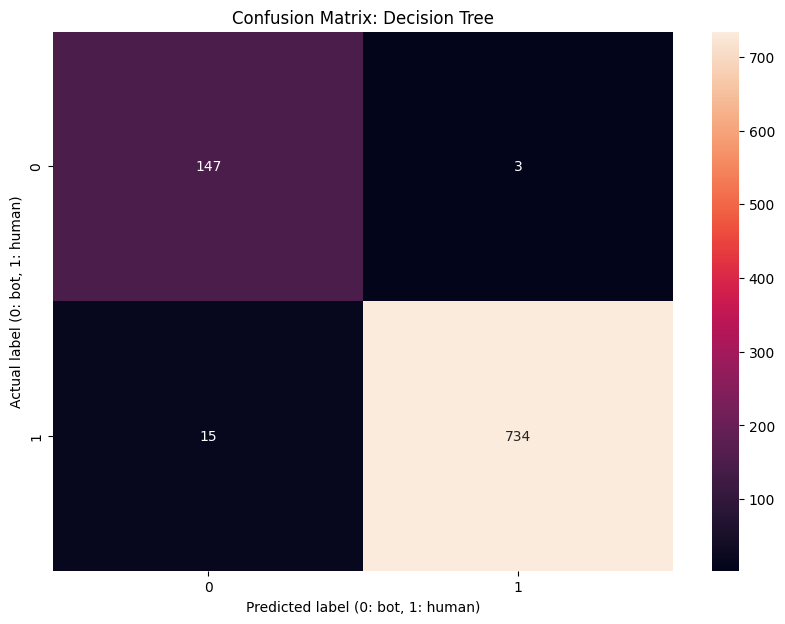

In [538]:
make_conf_matrix(labels_test=labels_test, predict=dt_predict, algo_name="Decision Tree")

# Supervised Learning: SVM

https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html

https://scikit-learn.org/stable/modules/svm.html#svm-classification

In [539]:
scaler = StandardScaler()
df_features_train_scaled: np.ndarray = scaler.fit_transform(df_features_train)
df_features_test_scaled: np.ndarray = scaler.transform(df_features_test)

svm_classifier = SVC(
    kernel='rbf',
    probability=True,
)
svm_classifier.fit(df_features_train_scaled, labels_train)
svm_predict: np.ndarray = svm_classifier.predict(df_features_test_scaled)
svm_accuracy: str = classification_report(labels_test, svm_predict)
print(svm_accuracy)

              precision    recall  f1-score   support

           0       0.87      0.96      0.91       150
           1       0.99      0.97      0.98       749

    accuracy                           0.97       899
   macro avg       0.93      0.97      0.95       899
weighted avg       0.97      0.97      0.97       899



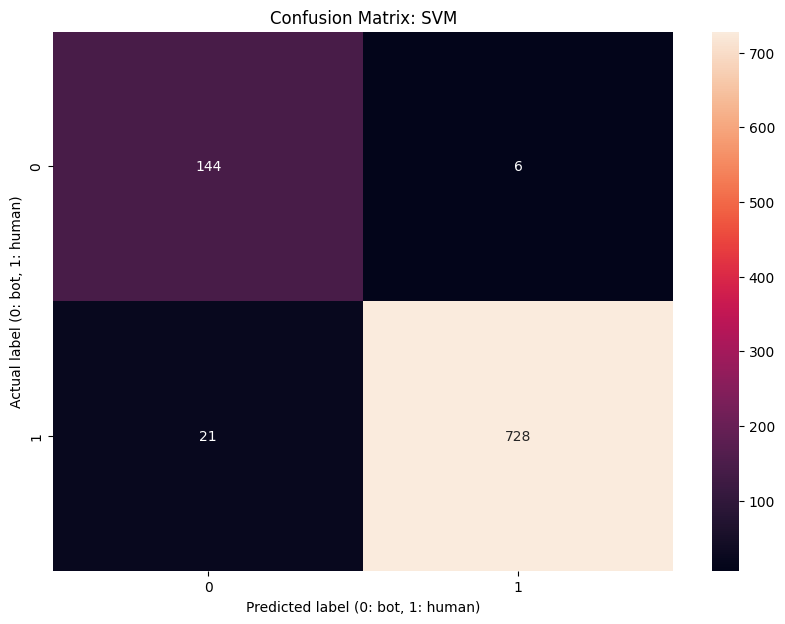

In [540]:
make_conf_matrix(labels_test=labels_test, predict=svm_predict, algo_name="SVM")

# Supervised Learning: Random Forrest

https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

https://scikit-learn.org/stable/modules/ensemble.html#forest

In [541]:
rf_classifier = RandomForestClassifier()

rf_classifier.fit(df_features_train, labels_train)
rf_predict: np.ndarray = rf_classifier.predict(df_features_test)
rf_accuracy: str = classification_report(labels_test, rf_predict)
print(rf_accuracy)

              precision    recall  f1-score   support

           0       0.96      0.99      0.98       150
           1       1.00      0.99      1.00       749

    accuracy                           0.99       899
   macro avg       0.98      0.99      0.99       899
weighted avg       0.99      0.99      0.99       899



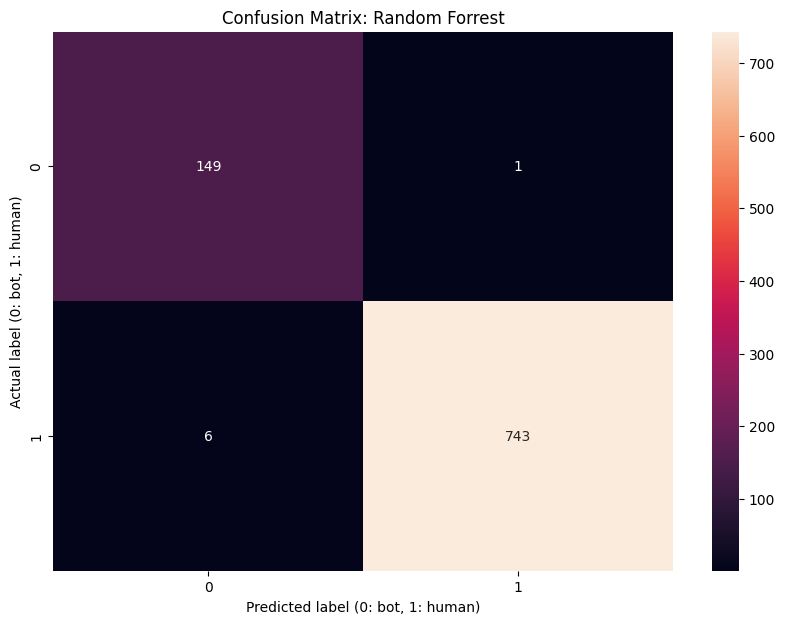

In [542]:
make_conf_matrix(labels_test=labels_test, predict=rf_predict, algo_name="Random Forrest")

# Receiver Operating Characteristic & Area Under Curve

https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html

https://scikit-learn.org/stable/modules/model_evaluation.html#roc-metrics

https://scikit-learn.org/stable/modules/generated/sklearn.metrics.auc.html

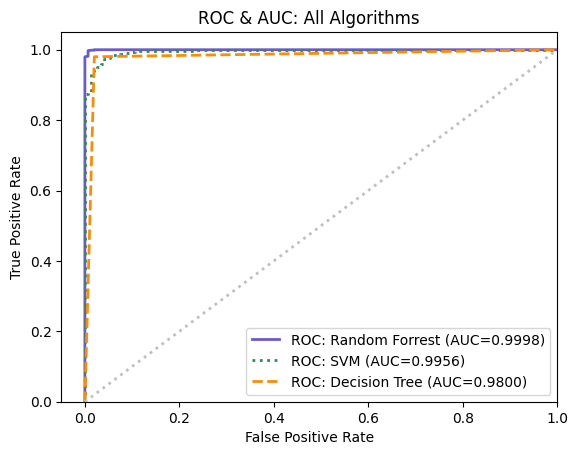

In [543]:
rf_fpr: np.ndarray
rf_tpr: np.ndarray
svm_fpr: np.ndarray
svm_tpr: np.ndarray
dt_fpr: np.ndarray
dt_tpr: np.ndarray

rf_fpr, rf_tpr, _ = roc_curve(labels_test, rf_classifier.predict_proba(df_features_test)[:, 1])
svm_fpr, svm_tpr, _ = roc_curve(labels_test, svm_classifier.predict_proba(df_features_test_scaled)[:, 1])
dt_fpr, dt_tpr, _ = roc_curve(labels_test, dt_classifier.predict_proba(df_features_test)[:, 1])

rf_auc: float = auc(rf_fpr, rf_tpr)
svm_auc: float = auc(svm_fpr, svm_tpr)
dt_auc: float = auc(dt_fpr, dt_tpr)

fig = plt.figure()
plt.plot(rf_fpr, rf_tpr, color='slateblue', lw=2, linestyle='-', label=f'ROC: Random Forrest (AUC={rf_auc:.4f})')
plt.plot(svm_fpr, svm_tpr, color='seagreen', lw=2, linestyle=':', label=f'ROC: SVM (AUC={svm_auc:.4f})')
plt.plot(dt_fpr, dt_tpr, color='darkorange', lw=2, linestyle='--', label=f'ROC: Decision Tree (AUC={dt_auc:.4f})')
plt.plot([0, 1], [0, 1], color='silver', lw=2, linestyle=':')
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC & AUC: All Algorithms')
plt.legend(loc="lower right")
fig.savefig(OUTPUT_SL_DIR / f"roc_auc_all.png")
plt.show()

# Example with GridSearchCV for parameter tuning

https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html

https://scikit-learn.org/stable/modules/grid_search.html#grid-search

In [553]:
param_grid = {
    'criterion': ['gini', 'entropy', 'log_loss'],
    'max_depth': list(range(10, 101, 10)),
    'min_samples_split': [2, 5, 10],
    'min_impurity_decrease': [0.0, 0.01, 0.02, 0.05],
    'splitter': ['best', 'random'],
}

grid_search = GridSearchCV(DecisionTreeClassifier(), param_grid, cv=5, verbose=0, n_jobs=-1)
grid_search.fit(df_features_train, labels_train)
print(f"Best parameters: {grid_search.best_params_}")

best_dt_classifier: DecisionTreeClassifier = grid_search.best_estimator_
dt_predict: np.ndarray = best_dt_classifier.predict(df_features_test)
dt_accuracy: str = classification_report(labels_test, dt_predict)
print(dt_accuracy)

Best parameters: {'criterion': 'entropy', 'max_depth': 40, 'min_impurity_decrease': 0.0, 'min_samples_split': 5, 'splitter': 'best'}
              precision    recall  f1-score   support

           0       0.93      0.98      0.95       150
           1       1.00      0.99      0.99       749

    accuracy                           0.98       899
   macro avg       0.96      0.98      0.97       899
weighted avg       0.99      0.98      0.98       899

